# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
    - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    - Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [299]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline
import seaborn as sbn

## 1. www.topuniversities.com

First we discovered with postman interceptor that the data is loaded from file 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'. We take the top 200 universities from from file and for every university save only fields that are required. Because some info is not listed on tha main page(number of faculty members and number of students), we use BeautifulSoup to get the additional info. To know which tags are we looking for, we had to examine the website.

This is run only first time to collect the data. Data is later saved to binary file and loaded from file on PC to save some time :)

In [300]:
#file that was discovered using Interceptor
url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'

#get the data
r = requests.get(url)

#get first 200 universities
data = r.json()['data'][:200]
universities = []

#for every university extract required fileds
#and use BeautifulSoup and university url to get additional info(number of faculty members and number of students)
for u in data:
    university = {
        'name': u['title'],
        'rank': u['rank_display'].replace('=',''),
        'country': u['country'],
        'region': u['region']
    }
    r = requests.get('https://www.topuniversities.com/'+u['url'])
    soup = BeautifulSoup(r.text, 'html.parser')
    
    faculty_total_div = soup.find('div', class_='total faculty')
    if faculty_total_div != None:
        university['faculty_total'] = faculty_total_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
    
    faculty_int_div = soup.find('div', class_='inter faculty')
    if faculty_int_div != None:
        university['faculty_international'] = faculty_int_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
        
    student_total_div = soup.find('div', class_='total student')
    if student_total_div != None:
        university['students_total'] = student_total_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
        
    student_int_div = soup.find('div', class_='total inter')
    if student_int_div != None:
        university['students_international'] = student_int_div.find('div', class_='number').text.replace('\n', '').replace(',', '')
    
    universities.append(university)


We create a dataframe from the previously created list of universities, and convert the following column values to float.

In [301]:
#create dataframe and convert following column values to float 
#we use float because some values have NaN value, which is not supported with int
df = pd.DataFrame(universities)
df['faculty_total'] = df ['faculty_total'].astype(float)
df['faculty_international'] = df ['faculty_international'].astype(float)
df['students_total'] = df ['students_total'].astype(float)
df['students_international'] = df ['students_international'].astype(float)
#save dataframe as binary file
df.to_pickle("topuniversities")

In [302]:
#load dataframe from binary file
df = pd.DataFrame()
df = pd.read_pickle('topuniversities')
df.head()

,country,faculty_international,faculty_total,name,rank,region,students_international,students_total
0,United States,1679.0,2982.0,Massachusetts Institute of Technology (MIT),1,North America,3717.0,11067.0
1,United States,2042.0,4285.0,Stanford University,2,North America,3611.0,15878.0
2,United States,1311.0,4350.0,Harvard University,3,North America,5266.0,22429.0
3,United States,350.0,953.0,California Institute of Technology (Caltech),4,North America,647.0,2255.0
4,United Kingdom,2278.0,5490.0,University of Cambridge,5,Europe,6699.0,18770.0


Now let's see which university is the best based on ratio between faculty members and students.

In [303]:
faculty_students_ratio = df['faculty_total']/df['students_total']
df_fac_st_ratio = df[['name', 'faculty_total', 'students_total']].assign(faculty_students_ratio = faculty_students_ratio.values).\
sort_values('faculty_students_ratio', ascending=False).head()
df_fac_st_ratio

,name,faculty_total,students_total,faculty_students_ratio
3,California Institute of Technology (Caltech),953.0,2255.0,0.422616
15,Yale University,4940.0,12402.0,0.398323
5,University of Oxford,6750.0,19720.0,0.342292
4,University of Cambridge,5490.0,18770.0,0.292488
16,Johns Hopkins University,4462.0,16146.0,0.276353


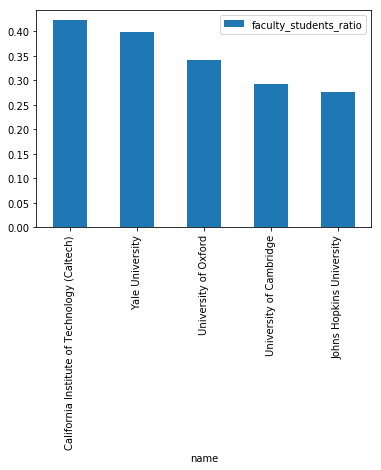

In [304]:
df_fac_st_ratio.plot.bar(x="name", y="faculty_students_ratio")

We can see that the best university is California Institute of Technology (Caltech).
Now let's see which university is the best in term of ratio of international students.

In [305]:
int_students_ratio = df['students_international']/df['students_total']
df_st_ratio=df[['name', 'students_international', 'students_total']].\
assign(int_students_ratio = int_students_ratio.values).sort_values('int_students_ratio', ascending=False).head()
df_st_ratio

,name,students_international,students_total,int_students_ratio
34,London School of Economics and Political Scien...,6748.0,9760.0,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),5896.0,10343.0,0.570047
7,Imperial College London,8746.0,16090.0,0.543567
198,Maastricht University,8234.0,16385.0,0.502533
47,Carnegie Mellon University,6385.0,13356.0,0.478062


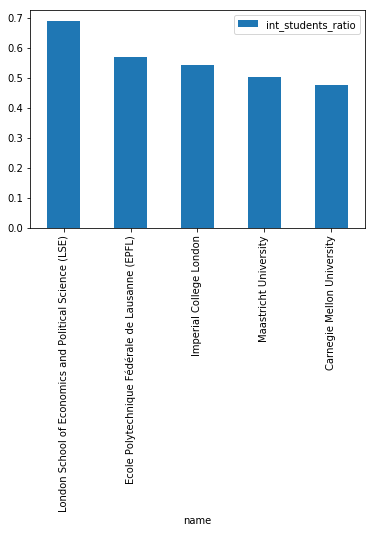

In [306]:
df_st_ratio.plot.bar(x="name", y="int_students_ratio")

We can see that the best university in terms of ratio of international students is London School of Economics and Political Science. And of course in second place is EPFL :)

Now let's see which country has best faculty members-students ratio.

In [307]:
by_country = df.groupby('country').sum().copy()
by_country_ratio1 = by_country.assign(faculty_students_ratio = by_country['faculty_total']/by_country['students_total']).\
sort_values('faculty_students_ratio', ascending = False)
by_country_ratio1.head()

,faculty_international,faculty_total,students_international,students_total,faculty_students_ratio
country,,,,,
Russia,373.0,6709.0,5098.0,30233.0,0.221910
Denmark,3904.0,11916.0,9543.0,67223.0,0.177261
Saudi Arabia,665.0,1062.0,989.0,6040.0,0.175828
Singapore,6079.0,9444.0,16168.0,58466.0,0.161530
Malaysia,655.0,2755.0,3476.0,17902.0,0.153893


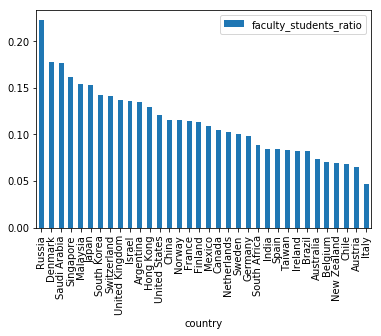

In [308]:
by_country_ratio1.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

We can see that in firts place is Russia and Italy is in last place. And now lets see which country has best international students ratio.

In [309]:
by_country_ratio2 = by_country.assign(int_students_ratio = by_country['students_international']/by_country['students_total']).\
sort_values('int_students_ratio', ascending = False)
by_country_ratio2.head()

,faculty_international,faculty_total,students_international,students_total,int_students_ratio
country,,,,,
Australia,11382.0,22034.0,106359.0,301994.0,0.352189
United Kingdom,30216.0,79934.0,199426.0,583621.0,0.341705
Hong Kong,6296.0,10166.0,24499.0,78838.0,0.310751
Austria,1572.0,4117.0,19667.0,63446.0,0.309980
Switzerland,9208.0,15323.0,32995.0,109112.0,0.302396


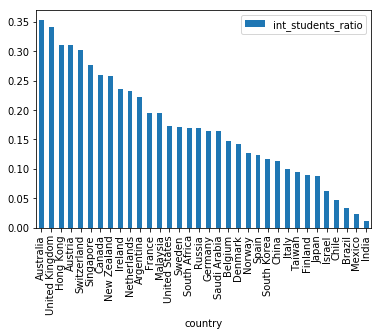

In [310]:
by_country_ratio2.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

We can see that in firts place is Australia, with 106359 international students and ratio of 0.352189. Switzerland is in fifth place. Now let's calculate the same thing, but grouped by region.

In [311]:
by_region = df.groupby('region').sum().copy()
by_region_ratio1 = by_region.assign(faculty_students_ratio = by_region['faculty_total']/by_region['students_total']).\
sort_values('faculty_students_ratio', ascending = False)
by_region_ratio1

,faculty_international,faculty_total,students_international,students_total,faculty_students_ratio
region,,,,,
Asia,25462.0,106734.0,110100.0,807003.0,0.132260
North America,43836.0,182123.0,292116.0,1546353.0,0.117776
Europe,67598.0,218358.0,449364.0,1957251.0,0.111564
Latin America,5648.0,45382.0,36871.0,435750.0,0.104147
Africa,379.0,1733.0,3325.0,19593.0,0.088450
Oceania,12786.0,25347.0,118798.0,350167.0,0.072385


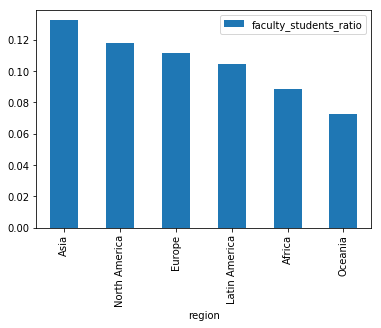

In [312]:
by_region_ratio1.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

When we group by region, we can see that in first place is Asia, and last Oceania. Now let's see what is the international student ratio.

In [313]:
by_region_ratio2 = by_region.assign(int_students_ratio = by_region['students_international']/by_region['students_total']).\
sort_values('int_students_ratio', ascending = False)
by_region_ratio2

,faculty_international,faculty_total,students_international,students_total,int_students_ratio
region,,,,,
Oceania,12786.0,25347.0,118798.0,350167.0,0.339261
Europe,67598.0,218358.0,449364.0,1957251.0,0.229589
North America,43836.0,182123.0,292116.0,1546353.0,0.188906
Africa,379.0,1733.0,3325.0,19593.0,0.169703
Asia,25462.0,106734.0,110100.0,807003.0,0.136431
Latin America,5648.0,45382.0,36871.0,435750.0,0.084615


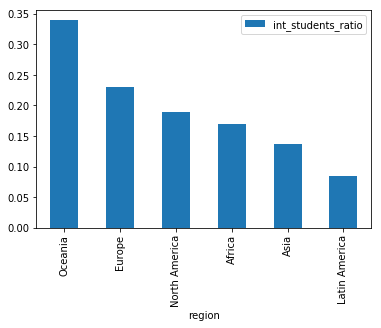

In [314]:
by_region_ratio2.drop(['faculty_international', 'faculty_total', 'students_international', 'students_total'], axis=1).plot.bar()

While the faculty members-student ratio in Oceania is lowest, it appears like they have the best ratio of international studnets.

## 2. Times Higher Education

In this section we're acquiring top 200 universities table from timeshighereducation.com. 
From the url:

 -https://www.timeshighereducation.com
/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json 

we can request json data file which contains university rankings and related information to each (such as location, name, student number etc). However there isn't any information regarding to the region of each university in this data, and thus we created country to region map from previous dataframe to match regions to each universities. In the first part we're making country to region map, and lastly we're populating our dataframe from json file that we've requested from timeshighereducation.com 

In [322]:
#requesting page with first 200 universities
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
#creating parser
data=r.json()['data'][:200]

#creating country to region look-up table from previous result
unique_countries=df['country'].unique()
country_to_region={}
for country in unique_countries:
    region=df[df['country']==country]
    country_to_region[country]=region['region'].iloc[0]

#exception countries that are not mentioned in previous dataframe
country_to_region['Luxembourg']='Europe'
country_to_region['Australia']='Australia'
country_to_region['New Zealand']='Europe'
#let's have a glimpse on our map
country_to_region['Singapore']

'Asia'

In this section we're creating empty dataset to contain our related variables and then populating it using json data

In [323]:
#declaring the dataframe
times=pd.DataFrame({'Name' : [], 
                    'Rank':[], 
                    'Country':[], 
                    'Region':[], 
                    'FM Total':[],
                    'FM International':[],
                    'Students Total':[],
                    'Students International':[]}) 
# processing the data json and populating the times dataframe
idx=1
for row in data:
    rank=int(row['rank'].replace("=",""))
    name=row['name']
    country=row['location']
    #Exception of country name
    if(country=="Russian Federation"): country="Russia"
    students=int(row['stats_number_students'].replace(",",""))
    ratio=float(row['stats_student_staff_ratio'])
    percent_i=float(row['stats_pc_intl_students'].replace("%",""))   
    #getting region information from country
    region=country_to_region[country]
    times.loc[idx]=[country,None,int(students/ratio),name,rank,region,students*percent_i/100,students]
    idx+=1  
#let's have a look at our dataframe
times.head()

,Country,FM International,FM Total,Name,Rank,Region,Students International,Students Total
1,United Kingdom,None,1822.0,University of Oxford,1.0,Europe,7755.42,20409.0
2,United Kingdom,None,1687.0,University of Cambridge,2.0,Europe,6436.15,18389.0
3,United States,None,339.0,California Institute of Technology,3.0,North America,596.43,2209.0
4,United States,None,2112.0,Stanford University,3.0,North America,3485.90,15845.0
5,United States,None,1284.0,Massachusetts Institute of Technology,5.0,North America,3800.18,11177.0


Since we're using sorting procedure lot for this session we're creating general case sorting function to tackle the task

In [324]:
#general sorting function
def sorter(data,column1,ratio=None,column2=None,filterby=None,filter_val=None,ascending=False):
    #copying ddata so that changes in data won't affect the original dataframe
    result=data.copy(True)
    #filtering the data by filter_val in filterby column
    if filterby!=None:
        result=data[data[filterby]==filter_val].copy(True)
    if ratio!=None:
        #if we have to filter data by ratio do this
        result[ratio]=result[column1].divide(result[column2])
        result=result.sort_values(ratio,ascending=ascending)
    else:
        result=result.sort_values(column1,ascending=ascending)
    return result

2.a Ranking the best universities by ratio between faculty members and students using sorting function

In [325]:
#sorting the times dataframe by faculty members and student ratio
times_fm_student=sorter(times,'FM Total','fm/student','Students Total')
times_fm_student.head()

,Country,FM International,FM Total,Name,Rank,Region,Students International,Students Total,fm/student
106,United States,None,3639.0,Vanderbilt University,105.0,North America,1561.43,12011.0,0.302972
110,Denmark,None,7413.0,University of Copenhagen,109.0,Europe,4255.30,30395.0,0.243889
13,United States,None,3604.0,Johns Hopkins University,13.0,North America,3719.52,15498.0,0.232546
12,United States,None,2826.0,Yale University,12.0,North America,2552.55,12155.0,0.232497
154,United States,None,2240.0,University of Rochester,153.0,North America,2794.44,9636.0,0.232462


The vanderbilt university has the highest faculty member to student ratio, and North american universities topped other universities in this criteriea

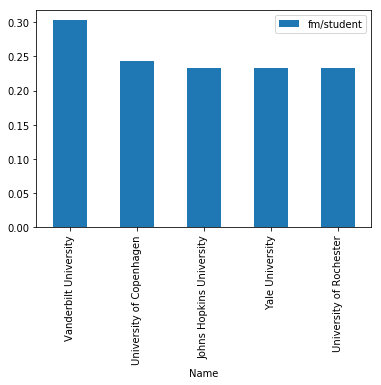

In [326]:
#checking the head of the dataset
times_fm_student.head().plot.bar(x="Name", y="fm/student")

Vanderbilt University has the highest faculty member to student number ratio which one faculty member to only 3 students

2.b Ranking best universities by ratio of international students

In [327]:
#sorting by international student ratio
times_intl_student=sorter(times,'Students International','intl/student','Students Total')
times_intl_student.head()

,Country,FM International,FM Total,Name,Rank,Region,Students International,Students Total,intl/student
25,United Kingdom,None,825.0,London School of Economics and Political Science,25.0,Europe,7146.15,10065.0,0.71
179,Luxembourg,None,340.0,University of Luxembourg,179.0,Europe,2832.33,4969.0,0.57
8,United Kingdom,None,1390.0,Imperial College London,8.0,Europe,8721.35,15857.0,0.55
38,Switzerland,None,886.0,École Polytechnique Fédérale de Lausanne,38.0,Europe,5460.40,9928.0,0.55
103,Netherlands,None,929.0,Maastricht University,103.0,Europe,8363.50,16727.0,0.50


When it comes to internationality, European universities peaked North American universities

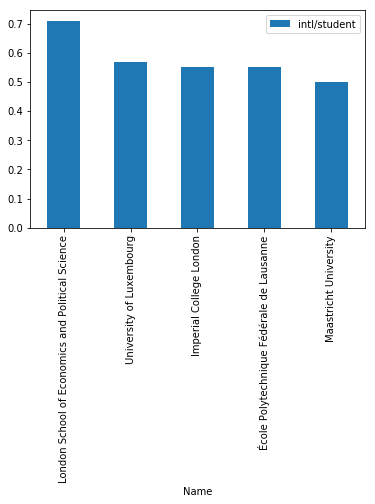

In [328]:
#checking out the dataframe ordered by international student ratio
times_intl_student.head().plot.bar(x="Name", y="intl/student")

Londol school of economics and political sciecne has the highest number of international student ratio which is around 70%. And EPFL takes fourth position

2.c.a Ranking countries by faculty and student ratio

In [329]:
#grouping dataframe by country and doing the sorting
by_country = times.groupby('Country').sum().copy()
times_by_country_ratio1 = by_country.assign(faculty_students_ratio = by_country['FM Total']/by_country['Students Total']).\
sort_values('faculty_students_ratio', ascending = False)
times_by_country_ratio1.head()

,FM Total,Rank,Students International,Students Total,faculty_students_ratio
Country,,,,,
Denmark,10596.0,371.0,9326.86,64110.0,0.165278
Russia,4004.0,194.0,6431.92,29236.0,0.136954
Japan,6464.0,120.0,4398.48,48481.0,0.133331
Italy,157.0,339.0,132.65,1205.0,0.130290
Switzerland,10048.0,666.0,32745.97,107852.0,0.093165


We can see Denmark has topped our list by faculty member to student ratio. And Japan took first placei n our list which makes it first among Asian countries

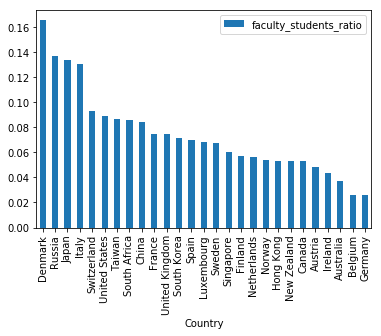

In [330]:
#graph to illustrate the dataframe
times_by_country_ratio1.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

2.c.b Ranking countries by international student ratio

In [331]:
#grouping dataframe by country and doing the sorting by international student ratio
times_by_country_ratio2 = by_country.assign(intl_students_ratio = by_country['Students International']/by_country['Students Total']).\
sort_values('intl_students_ratio', ascending = False)
times_by_country_ratio2.head()

,FM Total,Rank,Students International,Students Total,intl_students_ratio
Country,,,,,
Luxembourg,340.0,179.0,2832.33,4969.0,0.570000
United Kingdom,44425.0,3428.0,213059.74,596449.0,0.357214
Hong Kong,4140.0,443.0,25158.79,77663.0,0.323948
Australia,9937.0,616.0,83811.65,268630.0,0.311997
Singapore,3364.0,74.0,17085.29,56101.0,0.304545


When it comes to international student ratio, Luxembourg tops the list, perhaps due to number of universities in the list which is 1. And interestengly, 2 asian countries took place in first 5

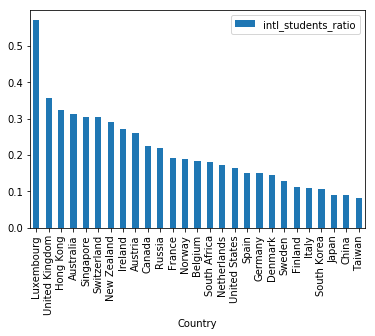

In [332]:
#graph about the data
times_by_country_ratio2.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

2.d.a Ranking regions by faculty and student ratio

In [333]:
#grouping dataframe by region and doing the sorting by faculty member to student ratio
by_region = times.groupby('Region').sum().copy()
times_by_region_ratio1 = by_region.assign(faculty_students_ratio = by_region['FM Total']/by_region['Students Total']).\
sort_values('faculty_students_ratio', ascending = False)
times_by_region_ratio1.head()

,FM Total,Rank,Students International,Students Total,faculty_students_ratio
Region,,,,,
Africa,1775.0,171.0,3739.50,20775.0,0.085439
North America,165553.0,5197.0,336270.47,1954934.0,0.084685
Asia,42628.0,2091.0,78837.67,530949.0,0.080286
Europe,128430.0,11963.0,490379.83,2173971.0,0.059076
Australia,9937.0,616.0,83811.65,268630.0,0.036991


Because of having fewest university Africa took first place in faculty to student ratio

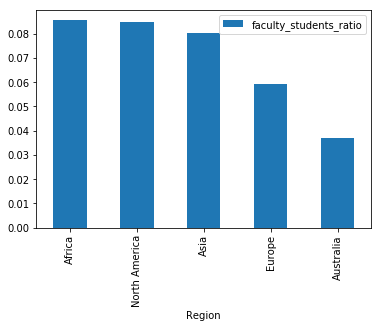

In [334]:
#graph to illustratethe data
times_by_region_ratio1.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

By region, Africa topped the ranking by faculty member to student ratio. Perhaps it's due to number of african universities among top 200 list is too low.

2.d.b Ranking regions by international student ratio

In [335]:
by_region = times.groupby('Region').sum().copy()
times_by_region_ratio2 = by_region.assign(intl_students_ratio = by_region['Students International']/by_region['Students Total']).\
sort_values('intl_students_ratio', ascending = False)
times_by_region_ratio2.head()

,FM Total,Rank,Students International,Students Total,intl_students_ratio
Region,,,,,
Australia,9937.0,616.0,83811.65,268630.0,0.311997
Europe,128430.0,11963.0,490379.83,2173971.0,0.225569
Africa,1775.0,171.0,3739.50,20775.0,0.180000
North America,165553.0,5197.0,336270.47,1954934.0,0.172011
Asia,42628.0,2091.0,78837.67,530949.0,0.148484


When it comes to internationality European universities again ranked higher than other regions, but Australia topped in this criteria

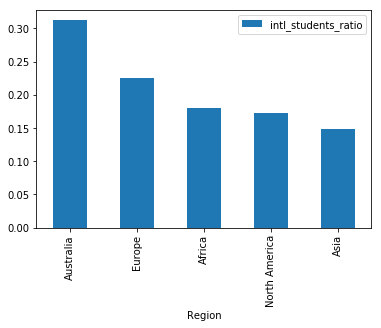

In [336]:
times_by_region_ratio2.drop(['FM Total', 'Rank', 'Students International', 'Students Total'], axis=1).plot.bar()

## 3. Merging the 2 dataframes

In this section we're merging the 2 dataframes that we've collected from 2 websites by their name. In two dataframes almost above half (~120) universities names were matched without any further processing, which text of names in topuniversities list contains that of timeshighereducation. But we've done further processing by analyzing the given names of 2 lists by words and characters.

In the following code we're filtering only relevant information from topuniversities data and preparing dataframe fro merging

In [337]:
#creating dataframe for merging
#top_merge dataframe will contains only columns which contain relevant information of topuniversity's list (name, rank, faculty member to student ratio, international student ratio)
top_merge=df.assign(top_fm_student=df['faculty_total']/df['students_total'])
top_merge=top_merge.assign(top_intl_student=df['students_international']/df['students_total'])
#dropping unnecessary columns
top_merge=top_merge.drop(['country','faculty_international','faculty_total','region','students_international','students_total'],axis=1)

top_merge.head()

,name,rank,top_fm_student,top_intl_student
0,Massachusetts Institute of Technology (MIT),1,0.269450,0.335863
1,Stanford University,2,0.269870,0.227422
2,Harvard University,3,0.193945,0.234785
3,California Institute of Technology (Caltech),4,0.422616,0.286918
4,University of Cambridge,5,0.292488,0.356899


In the following code we're filtering only relevant information from timeshighereducation data and preparing dataframe fro merging. And also we're adding 'name' column which contains each universities corresponding name in top_merge dataframe. If this cell has None value, then it means we can't find corresponding match.

In [338]:
#creating dataframe for merging
#times_merge dataframe will contains only columns which contain relevant information of timeshighereducation's list (name, rank, faculty member to student ratio, international student ratio)
times_merge=times.assign(times_fm_student=times['FM Total']/times['Students Total'])
times_merge=times_merge.assign(times_intl_student=times['Students International']/times['Students Total'])
#dropping unnecessary columns
times_merge=times_merge.drop(['Country','FM International','FM Total','Region','Students International','Students Total'],axis=1)
#additional column will be used to merge datasets by name
times_merge["name"]=None
times_merge.head()

,Name,Rank,times_fm_student,times_intl_student,name
1,University of Oxford,1.0,0.089274,0.38,None
2,University of Cambridge,2.0,0.091740,0.35,None
3,California Institute of Technology,3.0,0.153463,0.27,None
4,Stanford University,3.0,0.133291,0.22,None
5,Massachusetts Institute of Technology,5.0,0.114879,0.34,None


Note that columns of times higher education start with capital letter while that of top university are start with lowercase letters

First we're doing simplest but most efficient algorithm which checks string in top_merge contains if times_merge. If yes then we assume, we've found a match.

In [339]:
#list of all names of university in top university's list
top_names=top_merge['name'].unique()
#We're using 3 cascaded filters which each matches 2 list's names with certain condition and narrows down the possible names for the next filter
#first layer we're matching the names by the whole text
def name_checker1(a,blist):
    #for each possible name in top_names
    for b in blist:
        #if b contains a (name in times list) then it's a match. Thus return b
        if(a in b): return b
    #if there is no match then return None for the next layer
    return None
used=[]
#populating the name column in times_merge dataframe according to the matches in name_checker1
for idx in range(1,201):
    name=name_checker1(times_merge.at[idx,'Name'],top_names)
    if name!=None:
        #we're also keeping track of used possibilities of topuniversity's names list
        used.append(name)
    #inserting the name_checker result to times_merge dataframe
    times_merge.at[idx,'name']=name
top_names=list(set(top_names) - set(used))

Second, we're calculating the number of matched words between 2 names. If number of matched words is more than half of the number of whole name, then we assume it's a match. If not we'll return None value

In [340]:
#second layer by word
#in this layer we're checking if percentage of matched words are above threshold(0.5)?
def name_checker2(a,blist):
    #Since we can't assume a text is equal to b just by checking the words, we're keeping track of the best match
    #max_tuple will contain the percentage of matched words and corresponding top university's text
    max_tuple=(-1,0)
    for b in blist:
        #getting words from a
        awords=a.split(' ')
        cnt=0
        accepted=0
        #for each word in words of a
        for word in awords:
            #if following 2 conditions met we consider this not a word. Because the word unviersity is the most common word, it affects the percentage
            if 'Univer' in word: continue
            #if length of word is lower than 3 letter, the it is considered as prepositions
            if len(word) < 3 : continue
            #counting the matched words
            if word in b:
                cnt+=1
            accepted+=1
        #checking the maximum condition and keeping track of maximum match
        if max_tuple[0]<(cnt/accepted):
            max_tuple=(cnt/accepted,b)
    #if maximum match percentage is below 50% then it's considered not enough for match and thus we'll send it to 3rd layer
    if(max_tuple[0]>0.5): 
        return max_tuple[1]
    return None
used=[]
for idx in range(1,201):
    #if row is unmatched from first layer then do the following
    if times_merge.at[idx,'name']==None:
        name=name_checker2(times_merge.at[idx,'Name'],top_names)
        if name!=None:
            used.append(name)
        times_merge.at[idx,'name']=name
#removing used list from top_names, so that next layer can do the computation in more narrowed list
top_names=list(set(top_names) - set(used))

At last we're checking largest common subsequence from 2 names. And if it takes big part of the text, we can say, there is a match

In [341]:
#third layer by character
#In this layer we'r using the longest common sequence method on 2 texts.
def lcs(atext,btext):
    #As the name suggests this function returns longest common sequence from a and b texts
    #for the more information please visit https://en.wikipedia.org/wiki/Longest_common_subsequence_problem
    a_arr=list(atext)
    b_arr=list(btext)
    cnt=0
    v_lcs=0
    matrix=[]
    maxloc=[0,0]
    matrix.append([0]*(len(b_arr)+1))
    for i in range(1,len(a_arr)+1):
        matrix.append([])
        matrix[i].append(0)
        for j in range(1,len(b_arr)+1):
            matrix[i].append(0)
            if a_arr[i-1]==b_arr[j-1]:
                matrix[i][j]=matrix[i-1][j-1]+1
                if(v_lcs<matrix[i][j]):
                    v_lcs=matrix[i][j]
                    maxloc=[i,j]
            else:
                if(matrix[i-1][j]>matrix[i][j-1]):
                    matrix[i][j]=matrix[i-1][j]
                else:
                    matrix[i][j]=matrix[i][j-1]
    #now the length of longest common sequence is located at bottom right corner of the matrix
    #we're returning it's ratio to atext and btext lengths
    return matrix[len(a_arr)][len(b_arr)]/len(a_arr), matrix[len(a_arr)][len(b_arr)]/len(b_arr)
def name_checker3(a,blist):
    max_tuple=(-1,0)
    #removing common words in a to improve prediction
    t_a=a.replace('Universit','')
    t_a=t_a.replace('Institut','')
    #for each b
    for b in blist:
        #removing common words in b to improve prediction
        t_b=b.replace('Universit','')
        t_b=t_b.replace('Institut','')
        #compute the lcs. a_p equals to length of lcs divided by length of a, and it's same for b_p
        a_p,b_p=lcs(t_a,t_b)
        #we're considering the sum of both ratios in this case
        if max_tuple[0]<(a_p+b_p): max_tuple=(a_p+b_p,b)
    #we found threshold 1.261 empirically and it makes only 6-10 errors in this case
    #again if match score is below the threshold, we consider it not a match and if else, return the best match
    if(max_tuple[0]>=1.261): return max_tuple[1]
    return None
used=[]
for idx in range(1,201):
    if times_merge.at[idx,'name']==None:
        name=name_checker3(times_merge.at[idx,'Name'],top_names)
        if name!=None:
            used.append(name)
        times_merge.at[idx,'name']=name
top_names=list(set(top_names) - set(used))

#seeing the end result of 3 layers
times_merge.head()

,Name,Rank,times_fm_student,times_intl_student,name
1,University of Oxford,1.0,0.089274,0.38,University of Oxford
2,University of Cambridge,2.0,0.091740,0.35,University of Cambridge
3,California Institute of Technology,3.0,0.153463,0.27,California Institute of Technology (Caltech)
4,Stanford University,3.0,0.133291,0.22,Stanford University
5,Massachusetts Institute of Technology,5.0,0.114879,0.34,Massachusetts Institute of Technology (MIT)


Finally, we're mergin the 2 tables using the column 'name' in both dataframes

In [342]:
#merging the 2 dataframes that we've prepared for merge by column 'name'
universities=pd.merge(top_merge,times_merge,on='name')
universities= universities.drop('Name',1)
#renaming columns for convenience
universities= universities.rename(columns={'rank': 'top_rank', 'Rank': 'times_rank'})
universities= universities.dropna(axis=0, how='any') #removing one row which contains NaN
universities.top_rank= universities.top_rank.astype(str).astype(int) #converting top_rank from object to int

universities.head()

,name,top_rank,top_fm_student,top_intl_student,times_rank,times_fm_student,times_intl_student
0,Massachusetts Institute of Technology (MIT),1,0.269450,0.335863,5.0,0.114879,0.34
1,Stanford University,2,0.269870,0.227422,3.0,0.133291,0.22
2,Harvard University,3,0.193945,0.234785,6.0,0.112319,0.26
3,California Institute of Technology (Caltech),4,0.422616,0.286918,3.0,0.153463,0.27
4,University of Cambridge,5,0.292488,0.356899,2.0,0.091740,0.35


We've successfully matched 166 universities from 2 lists. And chance of finding match decreases as ranks in both list decrease.

## 4. Exploratory analysis

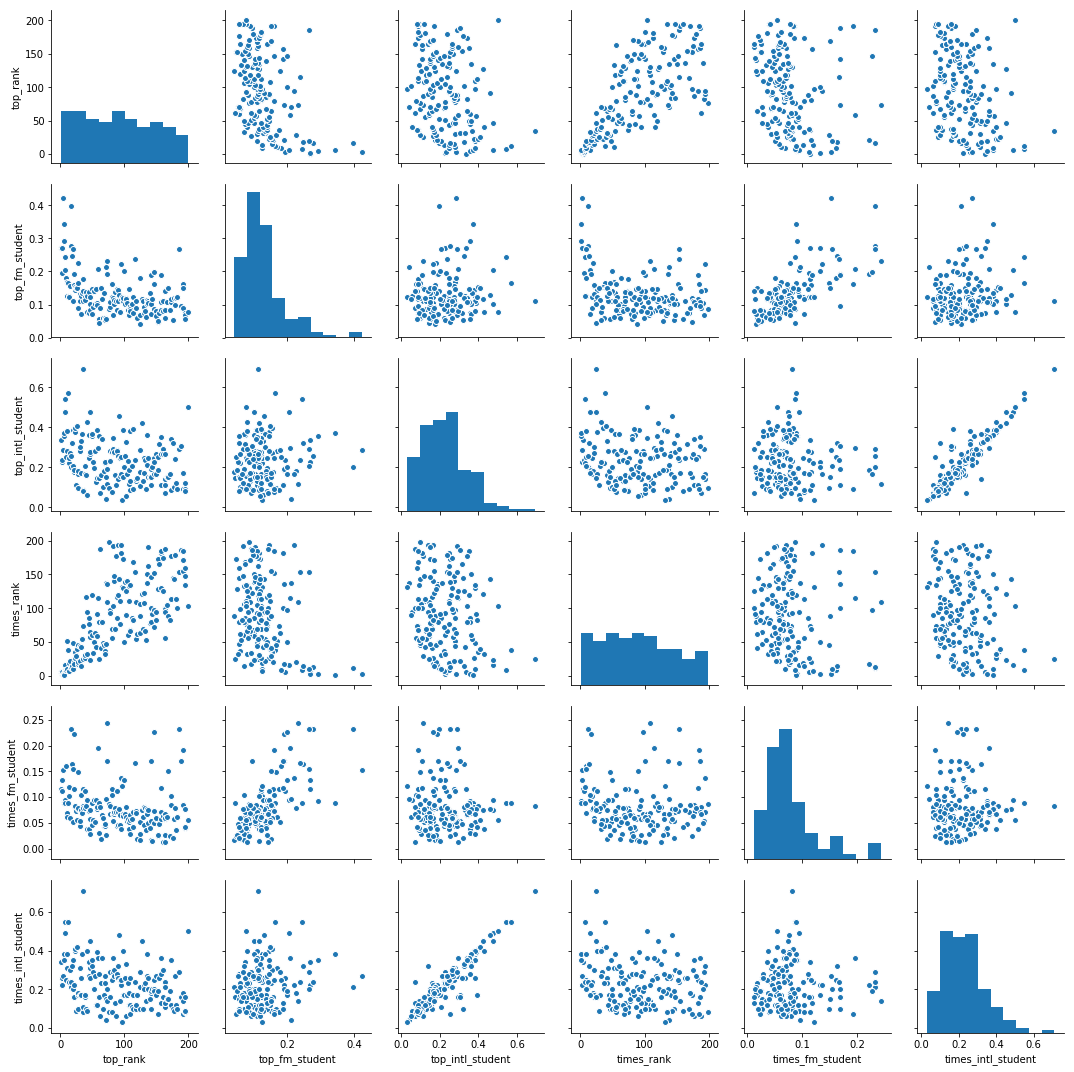

In [343]:
sbn.pairplot(universities)

In [344]:
correlations = universities.corr()
correlations

,top_rank,top_fm_student,top_intl_student,times_rank,times_fm_student,times_intl_student
top_rank,1.000000,-0.414227,-0.306218,0.696031,-0.228678,-0.328963
top_fm_student,-0.414227,1.000000,0.090420,-0.315462,0.680817,0.152226
top_intl_student,-0.306218,0.090420,1.000000,-0.222029,-0.055357,0.913495
times_rank,0.696031,-0.315462,-0.222029,1.000000,-0.117703,-0.209422
times_fm_student,-0.228678,0.680817,-0.055357,-0.117703,1.000000,-0.005657
times_intl_student,-0.328963,0.152226,0.913495,-0.209422,-0.005657,1.000000


 - We see that the same statistics ( the rank and the two ratios ) are highly correlated between the two websites, which is something that we were expecting.
 - On the other hand, the international dimention does not relate at all with a good ration between faculty members and students.
 - About the other correlations, is very interesting to notice how the ranking of the timeshighereducation is more related to the ratios computed with the data from topuniversities rather than with their own data!

## 5. Best University Ranking

To create our best ranking, we decided to use the following algorithm:
final_rank_score= ( top_rank + times_rank )/2 - ( top_fm_student + top_intl_student + times_fm_student + times_intl_student )
The lower will be this number, the higher will be the rank. With this approach we are taking into account the original rankings of the two websites and for the close ones we will let our ratios make the difference.

In [345]:
universities['Final_rank_score']=(universities['top_rank']+universities['times_rank'])/2-\
(universities['top_fm_student']+universities['top_intl_student']+\
 universities['times_fm_student']+universities['times_intl_student'])

universities.sort_values(by='Final_rank_score')

,name,top_rank,top_fm_student,top_intl_student,times_rank,times_fm_student,times_intl_student,Final_rank_score
1,Stanford University,2,0.269870,0.227422,3.0,0.133291,0.22,1.649417
0,Massachusetts Institute of Technology (MIT),1,0.269450,0.335863,5.0,0.114879,0.34,1.939808
5,University of Oxford,6,0.342292,0.372870,1.0,0.089274,0.38,2.315563
3,California Institute of Technology (Caltech),4,0.422616,0.286918,3.0,0.153463,0.27,2.367003
4,University of Cambridge,5,0.292488,0.356899,2.0,0.091740,0.35,2.408873
2,Harvard University,3,0.193945,0.234785,6.0,0.112319,0.26,3.698950
7,Imperial College London,8,0.244251,0.543567,8.0,0.087658,0.55,6.574523
8,University of Chicago,9,0.180645,0.249244,9.0,0.161257,0.25,8.158854
9,ETH Zurich - Swiss Federal Institute of Techno...,10,0.125006,0.381681,10.0,0.068476,0.38,9.044837
12,Princeton University,13,0.124799,0.222208,7.0,0.120427,0.24,9.292566


THANK YOU for your attention. SEANBI team... :)